#  Seminar 1: Tokenization & Word Embeddings

Сегодня мы начинаем работать с текстами. Первый шаг любого пайплайна для обработки текстов на естественных языках (NLP, natural language processing) — это векторизация текстов или их составляющих (буквосочетаний, слов, словосочетаний). Иными словами, перевод текстов из формы последовательности букв/слов/токенов в числовые векторы. Такие векторы обычно называют эмбеддингами. Для задач NLP (part of speech tagging, named entity recognition, генерация текста, etc.) бывает полезно пользоваться готовыми эмбеддингами, полученными за нас. Далее, при решении конкретной задачи, слова в текстах заменяют готовыми эмбеддингами и поверх этого дела уже строят разные модели.

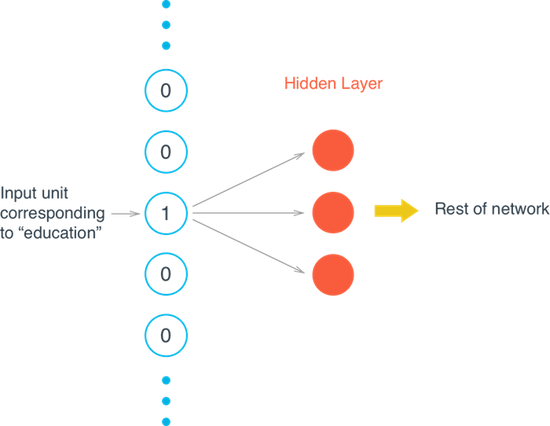

Конечно же, как мы это делали в предыдущем курсе, можно использовать one-hot кодирование для каждого слова. Далее one-hot векторы можно обрабатывать обычным линейным слоем, обучать его как часть модели и получать, в целом, похожую систему. Такой подход выливается в целый ряд проблем:

*   Во-первых, умножение строки в виде one-hot вектора на матрицу линейного слоя можно заменить на простую индексацию строки матрицы этого слоя.
*   Во-вторых, мы можем быть заинтересованы в хорошо обученных эмбеддингах на большом датасете (чтобы векторные представления хорошо отражали смысл слов), а в нашей конкретной задаче структура и/или количество данных могут отличаться.
*   В-третьих, если у нас есть основания полагать, что готовые эмбеддинги хорошо подходят для решаемой задачи, то мы можем немного сэкономить на обучении очень большого линейного слоя, ведь матрица эмбеддинигов имеет размеры `vocab_size x embed_size` и для стандартного словаря (десятки тысяч слов) может занимать больше 10 мегабайт памяти.

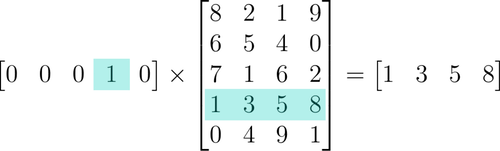

Подведём небольшие итоги. Наша цель — получить векторные представления одинакового размера для каждого слова из словаря. При этом перед обработкой слов из текста моделью, мы хотим по номеру слова в словаре брать из таблицы эмбеддингов нужный вектор и далее работать с ним как с признаковым описанием слова.

В идеале, мы хотим, чтобы полученные эмбеддинги отражали какое-то отношение между словами (семантику). Условно, мы хотим, чтобы векторы слов "любить" и "обожать" были ближе, чем векторы слов "любить" и "география" (за исключением, пожалуй, случаев, когда тексты, на которых мы учили представления, рассказывают о страстной любви к географии), но обо всём по порядку:

### План на сегодня:
1. Предобработка текста:
   * Токенизация
   * Стемминг
   * Лемматизация

2. Простая классификация:
   * TF-IDF

3. Word2Vec
   * Визуализация эмбеддингов


In [ ]:
# download the data:
!wget https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1 -O data/quora.txt
# alternative download link: https://yadi.sk/i/BPQrUu1NaTduEw

--2025-11-05 20:15:26--  https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/p0t2dw6oqs6oxpd6zz534/quora.txt?rlkey=bjupppwua4zmd4elz8octecy9&dl=1 [following]
--2025-11-05 20:15:26--  https://www.dropbox.com/scl/fi/p0t2dw6oqs6oxpd6zz534/quora.txt?rlkey=bjupppwua4zmd4elz8octecy9&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc78bb93884f8605aa91d3dbd5ec.dl.dropboxusercontent.com/cd/0/inline/C0lzv3H42NZHF68DpN47wUIIbI53tNw1onPZ1SEGhAEDrFAvR8LDlQL6CJxUY0yRSErdZ6BtGWfzUyaVlDSLLLBp6ng7DR1m2sh_BCOYiD0Bub52ruhhaokpsXz6vIbmUHU/file?dl=1# [following]
--2025-11-05 20:15:27--  https://uc78bb93884f8605aa91d3dbd5ec.dl.dropboxusercontent.com/cd/0/inline/C0lzv3H42NZ

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
data = list(open("data/quora.txt"))
data[50]

"What TV shows or books help you read people's body language?\n"

## 1. Предобработка текста

Мы выполняем предобработку текста, чтобы превратить неструктурированный, написанный человеком язык в последовательный и удобный для модели ввод.

Предобработка включает:

* токенизацию
* приведение к нижнему регистру
* нормализацию пунктуации и пробелов
* обработку стоп-слов
* лемматизацию/стемминг.

Эти шаги позволяют уменьшить размер словаря, снизить разреженность и удалить ненужные слова, чтобы уменьшить шум и позволить модели улавливать смысл, а не особенности форматирования. Это улучшает обобщающую способность модели (меньше дубликатов вроде “cat/Cat/CATS” или "выйти/вышел/вышла/выйду"), делает обучение быстрее и стабильнее.

Главное — умеренность: очищайте только то, что реально вредит качеству (например, HTML-разметку, дубликаты, очевидный шум), но сохраняйте семантику (отрицания, эмодзи, регистр — если он важен), чтобы не "убить" сам сигнал, который модель должна выучить.


### 1.1. Токенизация

Токенизация — это процесс разделения текста на токены (наборы символов). Совокупность всех полученных токенов образует наш словарь, на котором мы будем обучать модель.

Сегодня мы рассмотрим метод токенизации по словам (одно слово == один токен). Позже в курсе мы познакомимся и с другими вариантами токенизации, при которых токен — это не обязательно целое слово, а иногда лишь его часть.

Токенизацию можно реализовать с помощью [регулярных выражений](https://docs.python.org/3/library/re.html), но также это можно сделать и без них.


In [ ]:
import re
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# these two functions do the same job

def tokenize(text):
    for p in punctuation:
        text = text.replace(p, ' ')

    text = text.strip().split()
    return text

def tokenize(text):
    reg = re.compile(r'\w+')
    return reg.findall(text)

In [ ]:
print(tokenize(data[50]))

['What', 'TV', 'shows', 'or', 'books', 'help', 'you', 'read', 'people', 's', 'body', 'language']


**`nltk`** — это большая библиотека (сопоставимая с `numpy` для работы с матрицами). В ней реализованы методы для [токенизации](https://www.nltk.org/api/nltk.tokenize.html), [лемматизации](https://www.nltk.org/api/nltk.stem.wordnet.html), [стемминга](https://www.nltk.org/api/nltk.stem.html) и многих других задач.

In [ ]:
from nltk.tokenize import wordpunct_tokenize

print(wordpunct_tokenize(data[50]))

['What', 'TV', 'shows', 'or', 'books', 'help', 'you', 'read', 'people', "'", 's', 'body', 'language', '?']


**ЗАДАЧА**: привести весь текст к нижнему регистру и разделить его на токены

In [ ]:
data_tok = [tokenize(word.lower()) for word in data]

In [ ]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower(), map(' '.join, data_tok))), "please make sure to lowercase the data"

In [ ]:
print(data_tok[:2])

[['can', 'i', 'get', 'back', 'with', 'my', 'ex', 'even', 'though', 'she', 'is', 'pregnant', 'with', 'another', 'guy', 's', 'baby'], ['what', 'are', 'some', 'ways', 'to', 'overcome', 'a', 'fast', 'food', 'addiction']]


### 1.2. Убираем стоп-слова

Часто встречающиеся слова (например "the", "of", "for", etc.) не обеспечивают особого контекста для близлежащих слов. Если мы отбросим некоторые из них, мы сможем удалить часть шума из наших данных и взамен получить более быстрое обучение и лучшее представление.

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [ ]:
def remove_stopwords(tokenized_texts):
    clear_texts = []
    for words in tokenized_texts:
        clear_texts.append([word for word in words if word not in stop_words])

    return clear_texts

In [ ]:
data_tok = remove_stopwords(data_tok)

In [ ]:
print(data[50])
print(data_tok[50])

What TV shows or books help you read people's body language?

['tv', 'shows', 'books', 'help', 'read', 'people', 'body', 'language']


### 1.3. Лемматизация и стемминг

#### Лемматизация

**Лемматизация** — это процесс приведения слова к его канонической словарной форме (**лемме**):

* для существительных — именительный падеж, единственное число;
* для прилагательных — именительный падеж, единственное число, мужской род;
* для глаголов, причастий, деепричастий — форма инфинитива.

Для английского языка — `nltk.stem.WordNetLemmatizer`.
Для русского языка — `pymorphy2.MorphAnalyzer`.

Лемматизация — очень распространённый способ уменьшить размер словаря в классических NLP-пайплайнах.


#### Стемминг

**Стемминг** — это процесс приведения слова к его **основе (стему)** путём эвристического удаления приставок и суффиксов.
Он **не** гарантирует получение реального слова из словаря и, как правило, игнорирует часть речи и грамматику.

* Нет грамматической нормализации (только обрезка аффиксов).
* Результат может быть «не-словом» (например, `studies` → `studi`, `кошками` → `кошк`).
* Очень быстрый метод; часто сильнее сокращает словарь, но может объединять несвязанные формы и снижать точность.

Для английского языка — `nltk.stem.PorterStemmer`, `nltk.stem.SnowballStemmer("english")`.
Для русского языка — `nltk.stem.SnowballStemmer("russian")` (или другие реализации на основе Snowball).

#### Примеры

##### Английский:

| Исходная форма(ы) | Стемминг (алгоритм)        | Лемма (лемматизация) |
| ----------------- | -------------------------- | -------------------- |
| `studies`         | `studi` (Porter)           | `study`              |
| `goes`, `going`   | `go` (Porter)              | `go`                 |
| `went`            | `went` (Porter)            | `go`                 |
| `better` (прил.)  | `better` / `bett` (Porter) | `good`               |

##### Русский:

| Исходная форма(ы)           | Стемминг (алгоритм)         | Лемма (лемматизация) |
| --------------------------- | --------------------------- | -------------------- |
| `кошки`, `кошек`, `кошками` | `кошк` (Snowball)           | `кошка`              |
| `читал`, `читала`, `читали` | `чит` (Snowball)            | `читать`             |
| `дети`                      | `дет` (Snowball)            | `ребёнок`            |
| `лучше`                     | `лучш` / `лучше` (Snowball) | `хорошо` / `хороший` |

#### Когда что использовать?

*Стемминг*: быстрый, подходит для поисковых систем, где важна полнота; ожидается шум (`studi`, `comput`).
*Лемматизация*: медленнее и тяжелее, но обеспечивает более высокую точность и лучшее понимание смысла — особенно важна для морфологически богатых языков (например, русского) и при работе с исключениями/нерегулярностями (неправильные глаголы, исключение в правилах склонения).


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer

def lemmatize_text(tokenized_texts):
    lemmatized_data = []
    lemmatizer = WordNetLemmatizer()
    for words in tqdm(tokenized_texts):
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        lemmatized_data.append(lemmatized_words)
    return lemmatized_data

In [ ]:
from nltk.stem import PorterStemmer

def text_stemming(tokenized_texts):
    stemmed_data = []
    stemmer = PorterStemmer()
    for words in tqdm(tokenized_texts):
        stemmed_words = [stemmer.stem(word) for word in words]
        stemmed_data.append(stemmed_words)
    return stemmed_data

In [ ]:
lemmatized_data = lemmatize_text(data_tok)
stemmed_data = text_stemming(data_tok)

  0%|          | 0/537272 [00:00<?, ?it/s]

  0%|          | 0/537272 [00:00<?, ?it/s]

In [ ]:
print(lemmatized_data[50])
print(stemmed_data[50])

['tv', 'show', 'book', 'help', 'read', 'people', 'body', 'language']
['tv', 'show', 'book', 'help', 'read', 'peopl', 'bodi', 'languag']


## 2. Классификация

In [ ]:
data_train = pd.read_csv('data/ag_news_train.csv', sep='\t')
data_test = pd.read_csv('data/ag_news_test.csv', sep='\t')

In [ ]:
data_train.head(5)

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [ ]:
data_train.text[0]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [ ]:
labels_train = data_train['label']
labels_test = data_test['label']

len(data_train), len(data_test)

(120000, 7600)

Now let's check the classes distribution to decide on the metrics we are going to use.

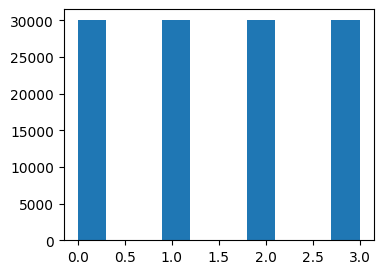

In [ ]:
plt.figure(figsize=(4, 3))
plt.hist(labels_train);

Иногда достаточно полезно проверить облако слов, когда работаем с текстовыми данными:

In [ ]:
from wordcloud import WordCloud

def create_cloud_graph(corpus):
    wordcloud = WordCloud(
        width=1600, height=800, max_words=200, background_color='white', collocations=False
    ).generate(' '.join(corpus))
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

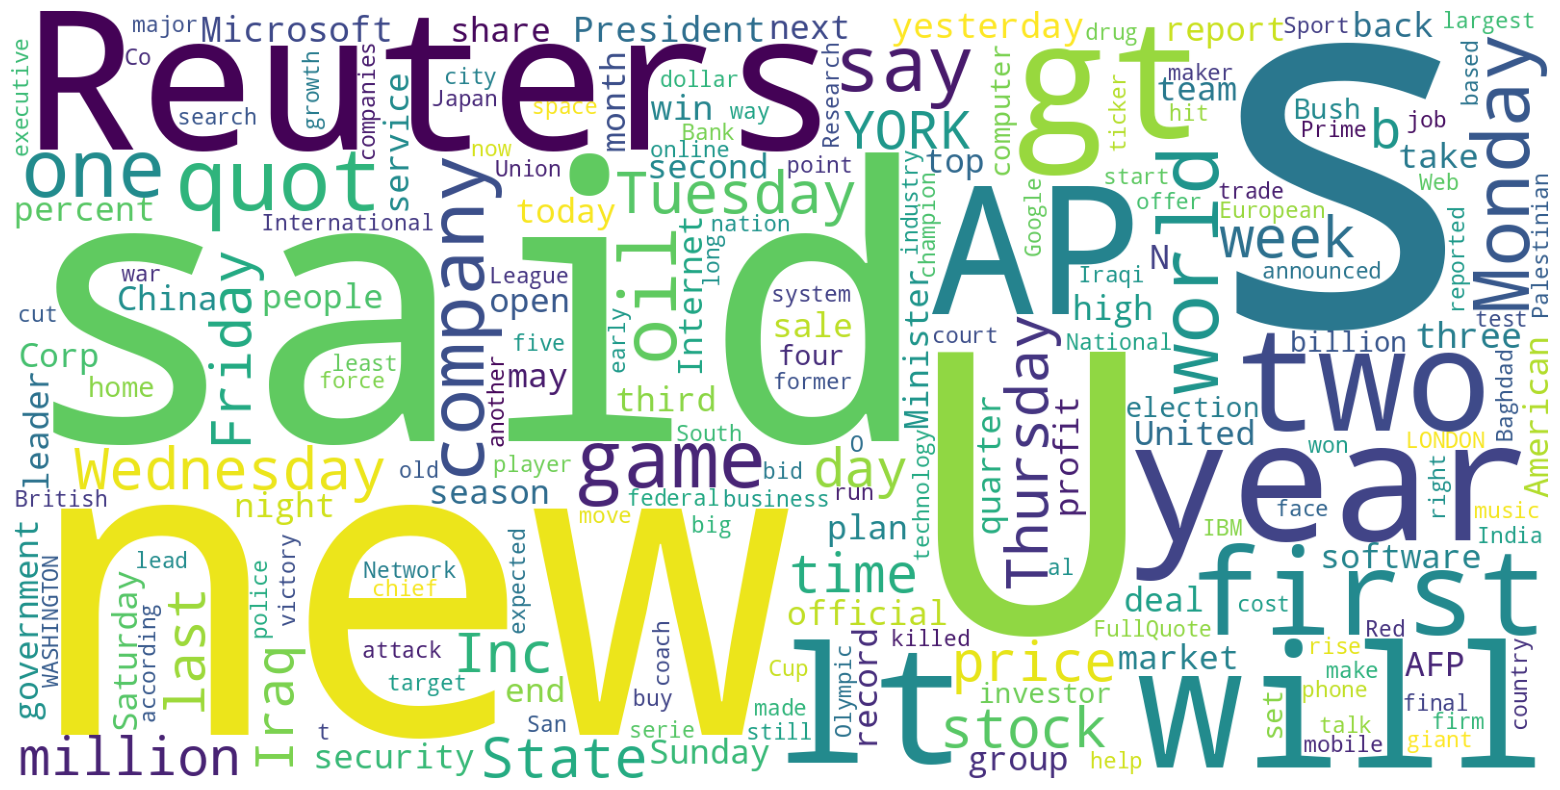

In [ ]:
create_cloud_graph(data_train['text'])

### TF-IDF

Говоря о классификации. В качестве базовой модели обучим TF-IDF.

1. **Частота термина (Term Frequency)**:
   $$\text{tf}(t, d) = \frac{N(t, d)}{\sum_{k \in V} N(k, d)},$$
   где $N(t, d)$ — количество вхождений слова $t$ в тексте $d$.

2. **Обратная частота документа (Inverse Document Frequency)**
   $$\text{idf}(t, D) = \log \frac{|D|}{|{d \in D \mid t \in d}|},$$

где $\left| {d \in D : t \in d} \right|$ — количество текстов в коллекции, содержащих слово $t$.

Полная формула:
$$\text{tf-idf}(t, d, D) = \text{tf}(t, d) \cdot \text{idf}(t, D).$$


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=4, max_df=0.95)
tfidf_vectorizer.fit(data_train['text']);

In [ ]:
tfidf_train = tfidf_vectorizer.transform(data_train['text'])
tfidf_test = tfidf_vectorizer.transform(data_test['text'])

In [ ]:
print(tfidf_train.shape)

(120000, 29350)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


def train_eval_model(train_X, test_X, train_y, test_y):
    model = LogisticRegression(max_iter=500)
    model.fit(train_X, train_y)

    train_pred = model.predict(train_X)
    test_pred = model.predict(test_X)

    train_acc = accuracy_score(train_y, train_pred)
    test_acc = accuracy_score(test_y, test_pred)

    print('Train accuracy:', round(train_acc, 3))
    print('Test accuracy: ', round(test_acc, 3))

In [ ]:
train_eval_model(tfidf_train, tfidf_test, labels_train, labels_test)

Train accuracy: 0.94
Test accuracy:  0.918


Дело в том, что такая конфигурация TF-IDF не улавливает смысл фраз вроде *«not done»*, так как считает слова *«not»* и *«done»* по отдельности, теряя контекст.

Исправить это можно с помощью **n-грамм** (например, биграмм), чтобы модель могла улавливать хотя бы выражения типа *«not done»* и другие отрицания.

Однако при этом необходимо **ограничить размер словаря**, иначе он станет слишком большим (порядка
$|Vocab| = N^2 + N$).

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=10, max_df=0.95, ngram_range=(1, 3))
tfidf_vectorizer.fit(data_train['text']);

In [ ]:
tfidf_train = tfidf_vectorizer.transform(data_train['text'])
tfidf_test = tfidf_vectorizer.transform(data_test['text'])

In [ ]:
train_eval_model(tfidf_train, tfidf_test, labels_train, labels_test)

Train accuracy: 0.951
Test accuracy:  0.92


## 3. Word Embeddings

>*настоятельно советую глянуть статью, если у вас остались вопросы: [illustrated word2vec by Jay Alammar](https://jalammar.github.io/illustrated-word2vec/)*


>*и посмотреть вот это видео о том, как обучается Word2Vec на примере Skip-Gram: [Word Vector Representations: word2vec by Stanford](https://youtu.be/ERibwqs9p38)*

![skipgram training pic](https://github.com/xufana/dsba_nlp/blob/main/seminars/pictures/skipgram.png?raw=1)

Вот небольшое напоминание о том, как получить эмбеддинги слова, используя метод `Skip-Gram`, в котором мы пытаемся предсказать слова контекста по центральному слову.

Если честно, существует очень много способов получить эмбеддинги текста. У каждого из них есть свои плюсы и минусы, так что выбирайте с умом, держа в голове конкретную задачу и её ограничения.

Сегодня для этих целей будем использовать `Word2Vec` из библиотеки [`gensim`](https://radimrehurek.com/gensim/auto_examples/). Это вторая большая библиотека, с которой мы сегодня познакомимся.

In [ ]:
! pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 46.2 MB/s eta 0:00:00


In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(data_tok,
                 vector_size=32,   # embedding vector size
                 min_count=5,      # consider words that occured at least 5 times
                 window=5).wv      # define context as a 5-word window around the target word

In [ ]:
# now you can get word vectors!
model.get_vector('word')

array([ 2.5937464 , -4.0427394 ,  0.78380907, -2.3970659 ,  2.6086297 ,
       -2.462771  ,  0.9119798 , -1.1448354 , -0.07306471,  0.07288256,
        1.7099288 , -1.770927  , -2.327059  , -1.7613411 , -0.29535392,
       -0.25443724, -0.25661427,  0.15539832,  2.1606143 , -1.750677  ,
       -0.2664537 ,  2.0606592 ,  0.02091262,  0.5003143 ,  1.955891  ,
        0.34892026,  0.35615003, -0.95286894, -0.7323437 , -0.4190057 ,
       -0.19825588, -0.3567969 ], dtype=float32)

In [ ]:
# or find similar words directly!
model.most_similar('word')

[('words', 0.8568949699401855),
 ('phrase', 0.8054166436195374),
 ('slang', 0.800258994102478),
 ('sentences', 0.8001689314842224),
 ('verb', 0.7984869480133057),
 ('sentence', 0.7978060841560364),
 ('grammatically', 0.7953571081161499),
 ('pronounce', 0.7826192378997803),
 ('translations', 0.7730740308761597),
 ('abbreviation', 0.7704409956932068)]

Вместо того чтобы обучать модель с нуля, мы можем загрузить **предобученные эмбеддинги**, полученные при обучении на гигабайтах текстов.

Обучение эмбеддингов всегда требует много времени, поэтому гораздо удобнее использовать уже готовые.

Например, обученные на ~~twitter~~ X.

In [ ]:
import gensim.downloader as api
model = api.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


Оказалось, наши эмбеддинги имеют линейную структуру:

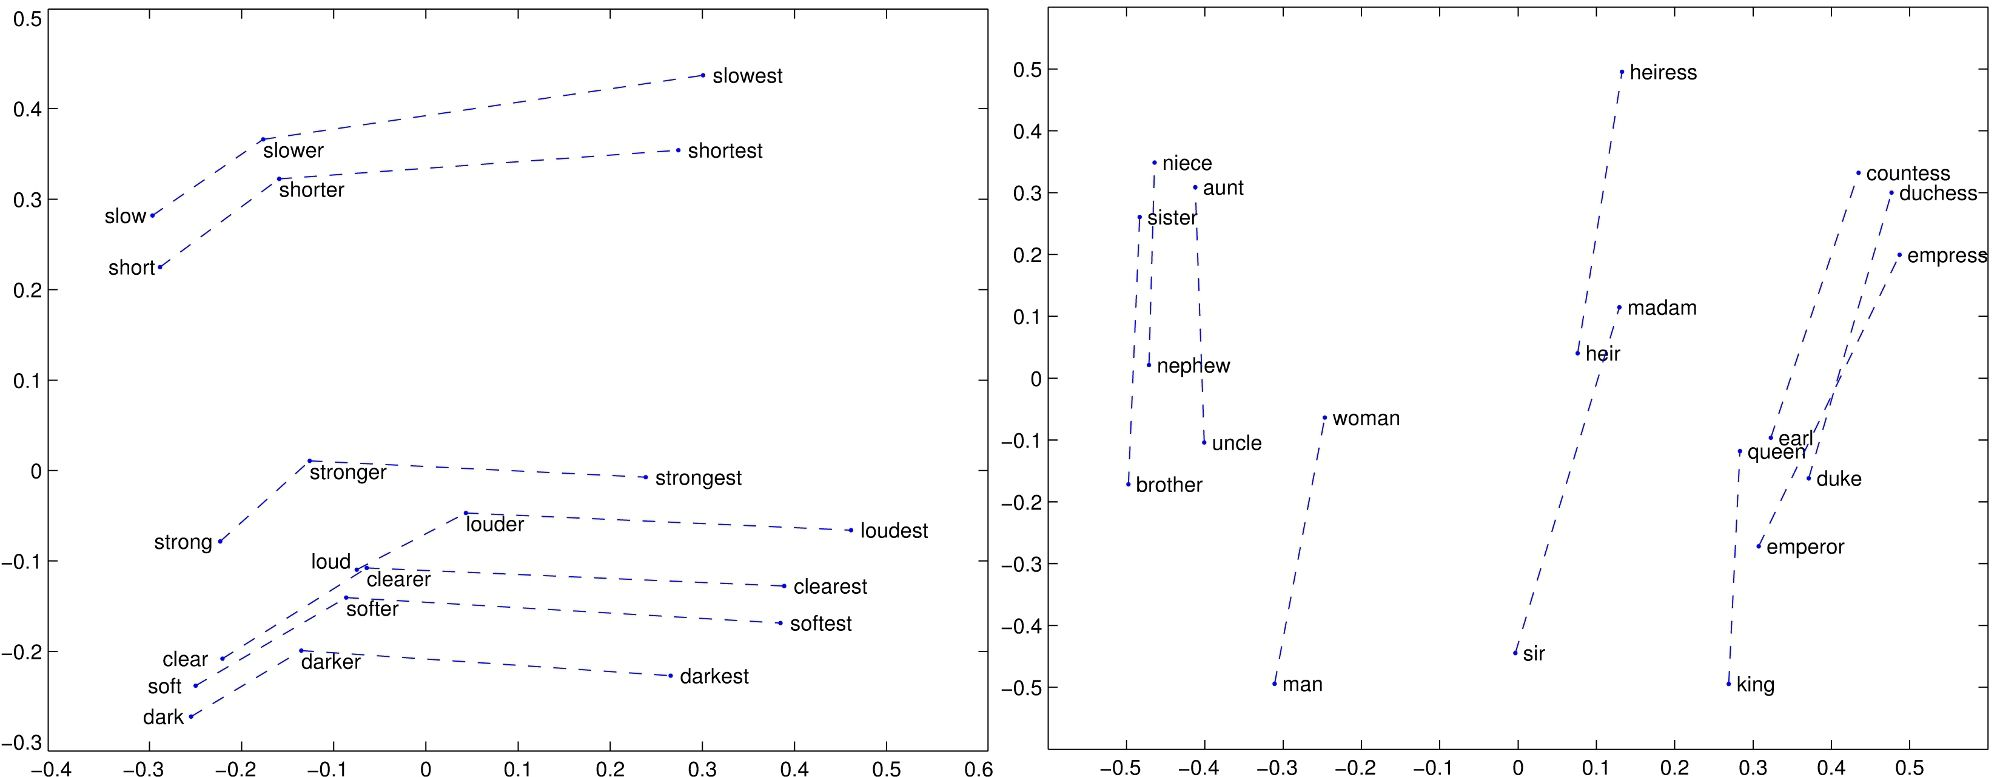

In [ ]:
model.most_similar(positive=["woman", "king"], negative=["man"])

[('queen', 0.7052316069602966),
 ('prince', 0.6666139364242554),
 ('mother', 0.6436765193939209),
 ('royal', 0.6417250633239746),
 ('father', 0.5952690243721008),
 ('african', 0.5883978009223938),
 ('princess', 0.5882176756858826),
 ('called', 0.5842776894569397),
 ('meets', 0.584027886390686),
 ('american', 0.5815179944038391)]

In [ ]:
model.most_similar(positive=["latte", "water"], negative=["milk"])

[('macchiato', 0.608176052570343),
 ('cappuccino', 0.5919400453567505),
 ('warm', 0.5744420886039734),
 ('espresso', 0.572758674621582),
 ('coffee', 0.5530275106430054),
 ('iced', 0.5521674156188965),
 ('mist', 0.5395065546035767),
 ('light', 0.531126081943512),
 ('mocha', 0.527961015701294),
 ('breeze', 0.5279032588005066)]

In [ ]:
model.most_similar(positive=['head', 'sock'], negative=['foot'])

[('pants', 0.6209893226623535),
 ('butt', 0.6058915853500366),
 ('blow', 0.6050280332565308),
 ('socks', 0.6032524108886719),
 ('monkey', 0.5986155867576599),
 ('beanie', 0.5947943925857544),
 ('heads', 0.5903893113136292),
 ('sack', 0.5851456522941589),
 ('tight', 0.5810109376907349),
 ('rocking', 0.579315185546875)]

### Визуализация эмбеддингов

Чтобы удобно визуализировать эмбеддинги, их можно отобразить на плоскости.
Однако для этого сначала нужно снизить размерность пространства до 2 или 3 измерений.
Существуют специальные методы для этого — мы рассмотрим **PCA** и **t-SNE**.

Мы будем работать с 1000 самыми популярными словами.

In [ ]:
words = model.index_to_key[:1000]

print(words[::100])

['<user>', '_', 'please', 'apa', 'justin', 'text', 'hari', 'playing', 'once', 'sei']


In [ ]:
# for each word, compute it's vector with model
word_vectors = np.array([model.get_vector(w) for w in words])

In [ ]:
assert isinstance(word_vectors, np.ndarray)
assert word_vectors.shape == (1000, 100)
assert np.isfinite(word_vectors).all()

#### Метод главных компонент (Principal Component Analysis, [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis))

Метод главных компонент используется для снижения размерности матрицы при сохранении максимального количества информации (дисперсии данных).
В геометрическом смысле метод находит оси, вдоль которых данные изменяются сильнее всего.


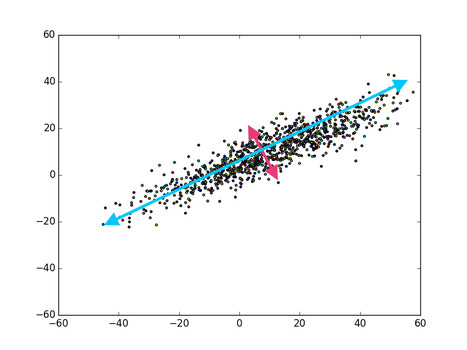


При нахождении этих осей решается следующая задача оптимизации:

$$|X W W^T - X|^2_2 \to \underset{W}{\min}$$

где:

* $X \in \mathbb{R}^{n \times m}$ — центрированная исходная матрица;
* $W \in \mathbb{R}^{m \times d}$ — матрица проекции;
* $n$ — число объектов, $m$ — число признаков, $d$ — желаемая размерность.

Из курсов линейной алгебры и машинного обучения вы знаете, что решение этой задачи находится с помощью *SVD-разложения*:

$$ X = U \Sigma V^T $$
$$ W = V_d $$

In [ ]:
from sklearn.decomposition import PCA

# PCA from sklearn center the data automatically
word_vectors_pca = PCA(n_components=2).fit_transform(word_vectors)

In [ ]:
assert word_vectors_pca.shape == (len(word_vectors), 2), "there must be a 2d vector for each word"

This function builds the interactive plot

Note: the visualization does not properly work in VS Code properly, please use other IDE

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook, output_file

# Enable inline plotting for Jupyter Notebook
output_notebook()

# Enable plotting for VS Code as a separate .html file
# output_file('plot.html')

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [ ]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

figure(id='p1006', ...)

### t-SNE

PCA позволяет снизить размерность, но полученные представления являются лишь проекциями данных на плоскость -- они отражают только высокоуровневые зависимости и поэтому не всегда подходят для качественной визуализации.

Мы же хотим получить такие точки, которые непосредственно отражают структуру многомерного пространства.
Более конкретно — чтобы точки, близкие друг к другу в исходном многомерном пространстве, располагались близко и на плоскости. И наоборот — чем дальше объекты в исходном пространстве, тем дальше они должны быть и на визуализации.

Именно эту задачу решает метод *t-SNE*.

Подробнее о нём можно почитать [здесь](https://distill.pub/2016/misread-tsne/) и [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).


In [ ]:
from sklearn.manifold import TSNE

word_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(word_vectors)

In [ ]:
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=words)

figure(id='p1057', ...)

### Визуализация фраз

Конечно, с помощью эмбеддингов слов целые тексты могут быть тоже визуализированы. Для этого нужно только каким-то образом получить один эмбеддинг предложения из набора эмбеддингов его слов. Какие идеи?

Самый простой способ -- посчитать среднее всех эмбеддингов в предложении, но есть ли способ лучше?

In [ ]:
def get_phrase_embedding(phrase):
    """
    Convert phrase to a vector by aggregating it's word embeddings. See description above.
    """
    # 1. lowercase phrase
    # 2. tokenize phrase
    # 3. average word vectors for all words in tokenized phrase
    # skip words that are not in model's vocabulary
    # if all words are missing from vocabulary, return zeros

    vector = np.zeros([model.vector_size], dtype='float32')

    # your code here

    tokenized_phrase = tokenize(phrase.lower())
    vectors = np.array([model.get_vector(token) for token in tokenized_phrase if token in model.index_to_key])

    return np.mean(vectors, axis=0)

In [ ]:
# let's only consider ~5k phrases for a first run.
chosen_phrases = data[::len(data) // 1000]

# compute vectors for chosen phrases
phrase_vectors = np.array([get_phrase_embedding(phrase) for phrase in chosen_phrases])

In [ ]:
assert isinstance(phrase_vectors, np.ndarray) and np.isfinite(phrase_vectors).all()
assert phrase_vectors.shape == (len(chosen_phrases), model.vector_size)

In [ ]:
# map vectors into 2d space with pca, tsne or your other method of choice
# don't forget to normalize

phrase_vectors_2d = TSNE(
    n_components=2, learning_rate='auto', init='random', perplexity=3
).fit_transform(phrase_vectors)

In [ ]:
draw_vectors(
    phrase_vectors_2d[:, 0],
    phrase_vectors_2d[:, 1],
    phrase=[phrase[:50] for phrase in chosen_phrases],
    radius=20
)

figure(id='p1108', ...)

Теперь для каждого вопроса мы можем найти наиболее похожие среди всех:

In [ ]:
# compute vector embedding for all lines in data
data_vectors = np.array([get_phrase_embedding(l) for l in data[:1000]])

In [ ]:
def find_nearest(query, k=10):
    """
    given text line (query), return k most similar lines from data, sorted from most to least similar
    similarity should be measured as cosine between query and line embedding vectors
    hint: it's okay to use global variables: data and data_vectors. see also: np.argpartition, np.argsort
    """

    # your code here

    query_vector = get_phrase_embedding(query)
    cosine = (data_vectors @ query_vector) / np.linalg.norm(data_vectors, axis=1)

    indices = np.argsort(cosine)[::-1][:k]

    nearest = np.array(data)[indices]

    return nearest

In [ ]:
find_nearest(query="How do i enter the matrix?", k=10)

array(['How do I make best use of IEEE?\n',
       "How do I find my life's goal?\n",
       "I don't have the energy to do anything anymore. What should I do?\n",
       'How do I crack the GRE?\n',
       'I have decided I want to become a police officer. What should I do and how do I do it?\n',
       'What kind of advanced C++ features I need to learn if I want to work for Google?\n',
       'How do I burn a DVD so that it will play automatically in a DVD player?\n',
       'How do I choose a topic for my blog?\n',
       'What should I do if I forgot the answers to my Apple ID questions?\n',
       'How can I read this time?\n'], dtype='<U1170')

In [ ]:
find_nearest(query="How does Trump?", k=10)

array(['Who is worse, Trump or Clinton?\n',
       'What does the 12th amendment mean?\n',
       'What does entertainment mean for you?\n',
       'How does HSTalks pay the speakers?\n',
       'Does CVS still develop film? Why or why not?\n',
       'How can you see exactly how may answers a question on Quora has when it says 100+ answers?\n',
       'How do you achieve the freezing point of hexane? How does it compare to methane?\n',
       'What is the intermediate value theorem? How do you find it?\n',
       'Is there any book to tell how human should think and behave after?\n',
       'What type of government does Turkey have? How does it compare to the one in Brazil?\n'],
      dtype='<U1170')

In [ ]:
find_nearest(query="Why don't i ask a question myself?", k=10)

array(["Why do I smile even when I don't want to?\n",
       "How do I tell my husband I don't think we're ready to try for a baby yet?\n",
       "My parents want me to become a doctor but I'm in love with cricket? what can i do to convince them?\n",
       "What is something that you know that I don't?\n",
       'How can I get a ride on a civilian C-130?\n',
       'How can I live a simple life?\n',
       "I don't have the energy to do anything anymore. What should I do?\n",
       'How can I record a FaceTime call on a Mac?\n',
       'What should I do if I forgot the answers to my Apple ID questions?\n',
       "How can I plan to become a multi billionaire? I'm 19 now?\n"],
      dtype='<U1170')